# GEONE - Markov chains on finite sets

A Markov chain $(X_k)_{k\geqslant 0}$ on a finite set of states $S=\{0,\ldots,n-1\}$ is a sequence
of random variables such that the distribution a the next step $k+1$ depends only on the current step $k$, which is known as the *Markov property*, or *memorylessness*. 

Such random process is described by a **transition kernel** (or simply **kernel**), a $n\times n$ matrix $P=(p_{ij})_{0\leqslant i, j < n}$ with $0 \leqslant p_{ij}\leqslant 1$ and $\sum_{j} p_{ij} = 1$. The coefficient $p_{ij}$ is the probability to have the state $j$ at the next step given the state $i$ at the current step, i.e.

- $p_{ij} = \mathbb{P}(X_{k+1}=j \vert X_k=i)$

This notebook illustrates some tools available in GEONE to deal with the simulation of Markov chains on finite sets.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.17


## Markov chains on finite sets - basic background theory
With the notations above, and denoting $\mu_k$ the probability mass function (pmf) over $S$ at step $k$ of the Markov chain, $X_k\sim \mu_k$, i.e. 

- $\mu_k(i) = \mathbb{P}(X_k=i), i=0,\ldots n-1$, 

we have

- $\mu_{k+1} = \mu_k\cdot P$

where $P$ is the transition kernel of the chain.

### Convergence of Markov chains
If the graph associated to the transition kernel is connected, then it exists a unique invariant pmf $\pi$ and, for any starting $X_0\sim\mu_0$, the distribution $\mu_k$ of $X_k$ conveges towards $\pi$. The chain $(X_k)$ is said stationary.

Let $Q$ be the **reverse transition kernel**, i.e. $q_{ij}$ is the probability to have the state $j$ at the previous step given the state $i$ at the current step. We have

$$p_{ij}\cdot\mu_k(i)=\mathbb{P}(X_{k+1}=j\vert X_k=i)\cdot\mathbb{P}(X_k=i) = \mathbb{P}(X_{k}=i\vert X_{k+1}=j)\cdot\mathbb{P}(X_{k+1}=j)=q_{ji}\cdot\mu_{k+1}(j).$$

If $\pi$ denotes the invariant pmf of the chain (assuming it exists), i.e. $\pi \cdot P = \pi$, and if $X_k\sim \pi$, then we have $\mu_k= \mu_{k+1}=\pi$ and $p_{ij}\cdot\pi(i) = q_{ji} \pi(j)$, i.e.

- $Q = \operatorname{diag(\pi)}^{-1} P^t\operatorname{diag(\pi)}.$

#### Symmetric transition kernel
If $P$ is symmetric, then $\pi = \left(\frac{1}{n}, \ldots, \frac{1}{n}\right)$ is invariant, because the columns of $P$ are the lines of $P$ and they sum to one. It follows that $Q=P$.

### Covariance of Markov chains
Let $\mathbf{1}_{X_k=i}$ the indicator variable for the state $i$ at step $k$ (i.e. with value $1$ if $X_k=1$ and $0$ otherwise). Assuming the chain $(X_k)$ is stationary, i.e. converging towards $X\sim\pi$, we have for large $k$:

- $\mathbb{E}\left(\mathbf{1}_{X_k=i}\right) = \mathbb{P}(X_k=i) \approx \pi(i)$

and for $l\geqslant 1$:

- $\operatorname{cov}\left(\mathbf{1}_{X_k=i}, \mathbf{1}_{X_{k+l}=j}\right) 
= \mathbb{E}\left(\mathbf{1}_{X_k=i}\mathbf{1}_{X_{k+l=j}}\right) -\mathbb{E}\left(\mathbf{1}_{X_k=i}\right)\mathbb{E}\left(\mathbf{1}_{X_{k+l=j}}\right)
= \mathbb{P}(X_k=i, X_{k+l}=j) - \pi(i)\pi(j).$

As

$$
\begin{array}{ll}
&\mathbb{P}(X_k=i, X_{k+l}=j) \\[2mm]
&\qquad = \sum_{i_1,\ldots,i_{l-1}} \mathbb{P}(X_k=i,X_{k+1}=i_1,\ldots,X_{k+l-1}=i_{l-1},X_{k+l}=j)\\[2mm]
&\qquad = \sum_{i_1,\ldots,i_{l-1}} \mathbb{P}(X_k=i,X_{k+1}=i_1,\ldots,X_{k+l-1}=i_{l-1}) \cdot \mathbb{P}(X_{k+l}=j\vert X_k=i,X_{k+1}=i_1,\ldots,X_{k+l-1}=i_{l-1})\\[2mm]
&\qquad = \sum_{i_1,\ldots,i_{l-1}} \mathbb{P}(X_k=i,X_{k+1}=i_1,\ldots,X_{k+l-1}=i_{l-1}) \cdot \mathbb{P}(X_{k+l}=j\vert X_{k+l-1}=i_{l-1})\\[2mm]
&\qquad = \sum_{i_1,\ldots,i_{l-1}} \mathbb{P}(X_k=i) \cdot \mathbb{P}(X_{k+i}=i_1\vert X_{k}=i)\cdots \mathbb{P}(X_{k+l-1}=i_{l-1}\vert X_{k+l-2}=i_{l-2})\mathbb{P}(X_{k+l}=j\vert X_{k+l-1}=i_{l-1})\\[2mm]
&\qquad = \sum_{i_1,\ldots,i_{l-1}} \mathbb{P}(X_k=i) p_{i,i_1}p_{i_1,i_2}\cdots p_{i_{l-1},j}\\[2mm]
&\qquad = \mathbb{P}(X_k=i) \left(P^l\right)_{ij} \\[2mm]
&\qquad \approx \pi(i) \left(P^l\right)_{ij},
\end{array}
$$

we have 

- $\operatorname{cov}\left(\mathbf{1}_{X_k=i}, \mathbf{1}_{X_{k+l}=j}\right) 
\approx \pi(i) \left[\left(P^l\right)_{ij}-\pi(j)\right].$


## Pre-defined kernels
The module `geone.markovChain` provides functions to define specific kernels.

### Kernel - function `geone.markovChain.mc_kernel1`
This function sets (returns) the $n\times n$ symmetric kernel

- $P = \left(\begin{array}{cccc}
p                & \frac{1-p}{n-1}  & \ldots          & \frac{1-p}{n-1}\\
\frac{1-p}{n-1}  & \ddots           & \ddots          & \vdots\\
\vdots           & \ddots           & \ddots          & \frac{1-p}{n-1}\\
\frac{1-p}{n-1}  & \ldots           & \frac{1-p}{n-1} & p
\end{array}\right)$

where $0 \leqslant p < 1$. The associated graph is connected and then any chain is stationary.

According to this kernel, from one step to the next one:
- the state remains unchanged with probability $p$,
- the state changes to any other state with probability $(1-p)/(n-1)$.

As $P$ is symmetric, the invariant distribution is $\pi=\left(\frac{1}{n}, \ldots, \frac{1}{n}\right)$.

### Kernel - function `geone.markovChain.mc_kernel2`
This function sets (returns) the $n\times n$ kernel

- $P = \left(\begin{array}{cccccc}
p             & 1-p    & 0             & \ldots        & 0      & 0\\
\frac{1-p}{2} & p      & \frac{1-p}{2} & \ddots        &        & 0\\
0             & \ddots & \ddots        & \ddots        & \ddots & \vdots\\
\vdots        & \ddots & \ddots        & \ddots        & \ddots & 0\\
0             &        & \ddots        & \frac{1-p}{2} &  p     & \frac{1-p}{2}\\
0             & 0      & \ldots        &     0         & (1-p)  & p
\end{array}\right)$

where $0 \leqslant p < 1$. The associated graph is connected and then any chain is stationary.

According to this kernel, from one step to the next one:
- the state remains unchanged with probability $p$,
- the state $i$, $0<i<n-1$, changes to the state at right ($i+1$) or at left ($i-1$) with probability $(1-p)/2$, 
- the state $0$ (resp. $n-1$) changes to the state $1$ (reps. $n-2$) with probability $1-p$.

The invariant distribution is $\pi= \left(\frac{1}{2(n-1)}, \frac{1}{n-1}, \ldots, \frac{1}{n-1}, \frac{1}{2(n-1)}\right)$.

### Kernel - function `geone.markovChain.mc_kernel3`
This function sets (returns) the $n\times n$ kernel

- $P = \left(\begin{array}{ccccc}
p          & (1-p)q & 0          & \ldots     & (1-p)(1-q)\\
(1-p)(1-q) & \ddots & \ddots     &            &0\\
0          & \ddots & \ddots     & \ddots     &\vdots\\
\vdots     & \ddots & \ddots     & \ddots     & 0\\
0          &        & \ddots     & \ddots     & (1-p)q\\
(1-p)q     & 0      & \ldots     & (1-p)(1-q) & p
\end{array}\right)$

where $0 \leqslant p < 1$ and $0 \leqslant q \leqslant 1$ are independent. The associated graph is connex and then any chain is stationary.

According to this kernel, from one step to the next one:
- the state remains unchanged with probability $p$,
- the state ($i$) changes to the state at right ($i+1$) with probability $(1-p)q$ (identifying "state $n$" with state $0$), and to the state at left ($i-1$) with probabibility $(1-p)(1-q)$, (identifying "state $-1$" with state $n-1$).

As the sum of each column in $P$ is equal to one, the invariant distribution is $\pi=\left(\frac{1}{n}, \ldots, \frac{1}{n}\right)$. Note that if $q=1/2$, the kernel is symmetric.

### Kernel - function `geone.markovChain.mc_kernel4`
This function sets (returns) the $n\times n$ kernel

- $P = \left(\begin{array}{ccccc}
q      & 0      & \ldots & 0      & 1-q\\
0      & \ddots & \ddots & \vdots & \vdots\\
\vdots & \ddots & \ddots & 0      & \vdots\\
0      & \ldots &  0     & q      & 1-q\\
\frac{1-p}{n-1} & \ldots & \ldots &\frac{1-p}{n-1}& p
\end{array}\right)$

where $0 \leqslant p < 1$ and $0 \leqslant q < 1$ are independent. The associated graph is connex and then any chain is stationary.

According to this kernel, from one step to the next one:
- the state $0\leqslant i < n-1$ remains unchanged with probability $q$ and change to the state $n-1$ with probability $1-q$,
- the state $i=n-1$ remains unchanged with probability $p$ and change to any other state with probability $(1-p)/(n-1)$.

The invariant distribution is $\pi=\left(\frac{1}{n-1}\cdot\frac{1-p}{2-p-q},\ldots,\frac{1}{n-1}\cdot\frac{1-p}{2-p-q}, \frac{1-q}{2-p-q}\right)$. Note that if $q=1-\frac{1-p}{n-1}$, the kernel is symmetric.

## Simulation of Markov chains

### Settings
Define number of categories (states), their values and the transition kernel.

In [3]:
# Y: stationary stochastic process given by a markov chain
# --------------------------------------------------------

# --------------------------------------------------------------
# Categories
# ----------
# Number of categories (states)
ncat = 4

# Category values
categVal = np.array([1, 2, 3, 4])

# Category colors (for further plot)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']

# Transition kernel
# -----------------
p = 0.95
kernel = gn.markovChain.mc_kernel1(ncat, p)  # kernel #1
# --------------------------------------------------------------

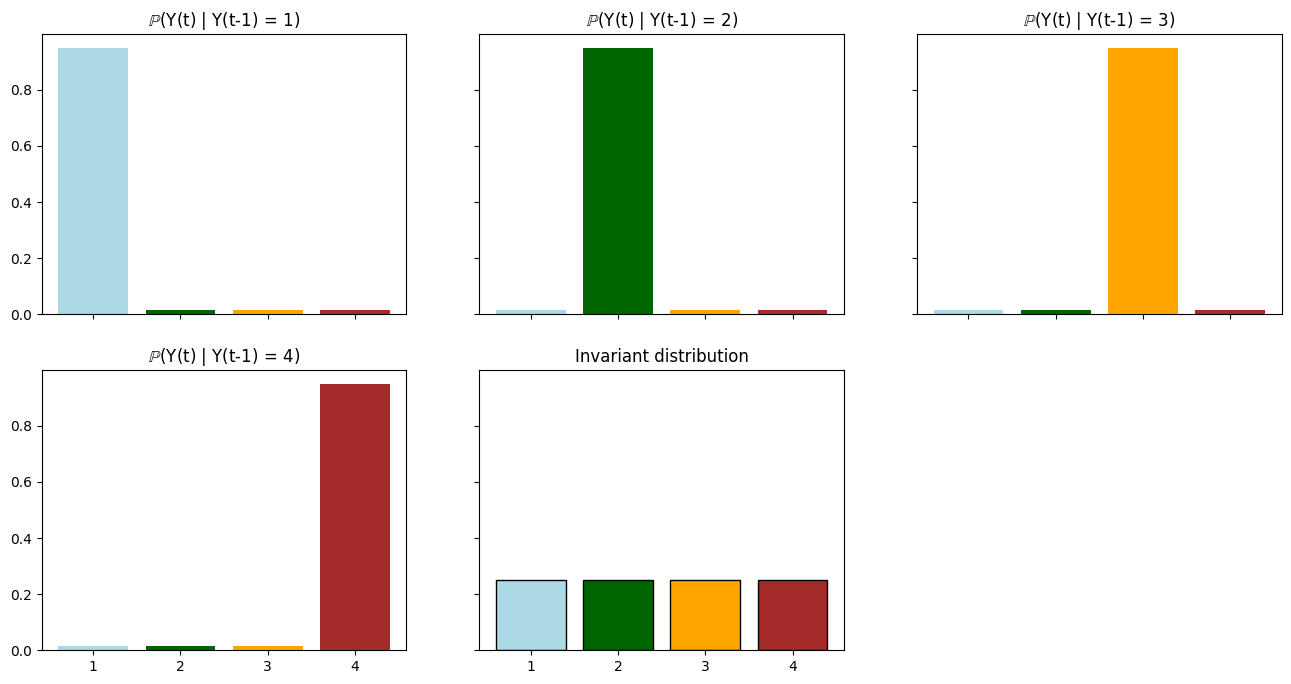

In [4]:
# Invariant distribution
pinv = gn.markovChain.compute_mc_pinv(kernel)

# Plot transition probabilities and invariant distribution
# --------------------------------------------------------
nf = ncat + 1
nr = int(np.sqrt(nf))
nc = nf // nr + 1*(nf%nr > 0)
hmin = 0.0
hmax = 1.05*max(kernel.max(), pinv.max())

plt.subplots(nr, nc, sharex=True, sharey=True, figsize=(16,8))

for i in range(ncat):
    plt.subplot(nr, nc, i+1)
    plt.bar(np.arange(ncat), kernel[i], color=categCol, tick_label=categVal)
    plt.ylim((hmin, hmax))
    plt.title(r'$\mathbb{P}$' + f'(Y(t) | Y(t-1) = {categVal[i]})')

plt.subplot(nr, nc, ncat+1)
plt.bar(np.arange(ncat), pinv, color=categCol, edgecolor='black', tick_label=categVal)
plt.ylim((hmin, hmax))
plt.title(f'Invariant distribution')

for i in range(ncat+2, nr*nc+1):
    plt.subplot(nr, nc, i)
    plt.axis('off')

plt.show()

### Generate unconditional Markov chains

Kernel:
 [[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]
Invariant distribution, empirical (pinv_emp): [0.2412  0.25938 0.24802 0.2514 ]
Invariant distribution, theoretical (pinv)  : [0.25 0.25 0.25 0.25]


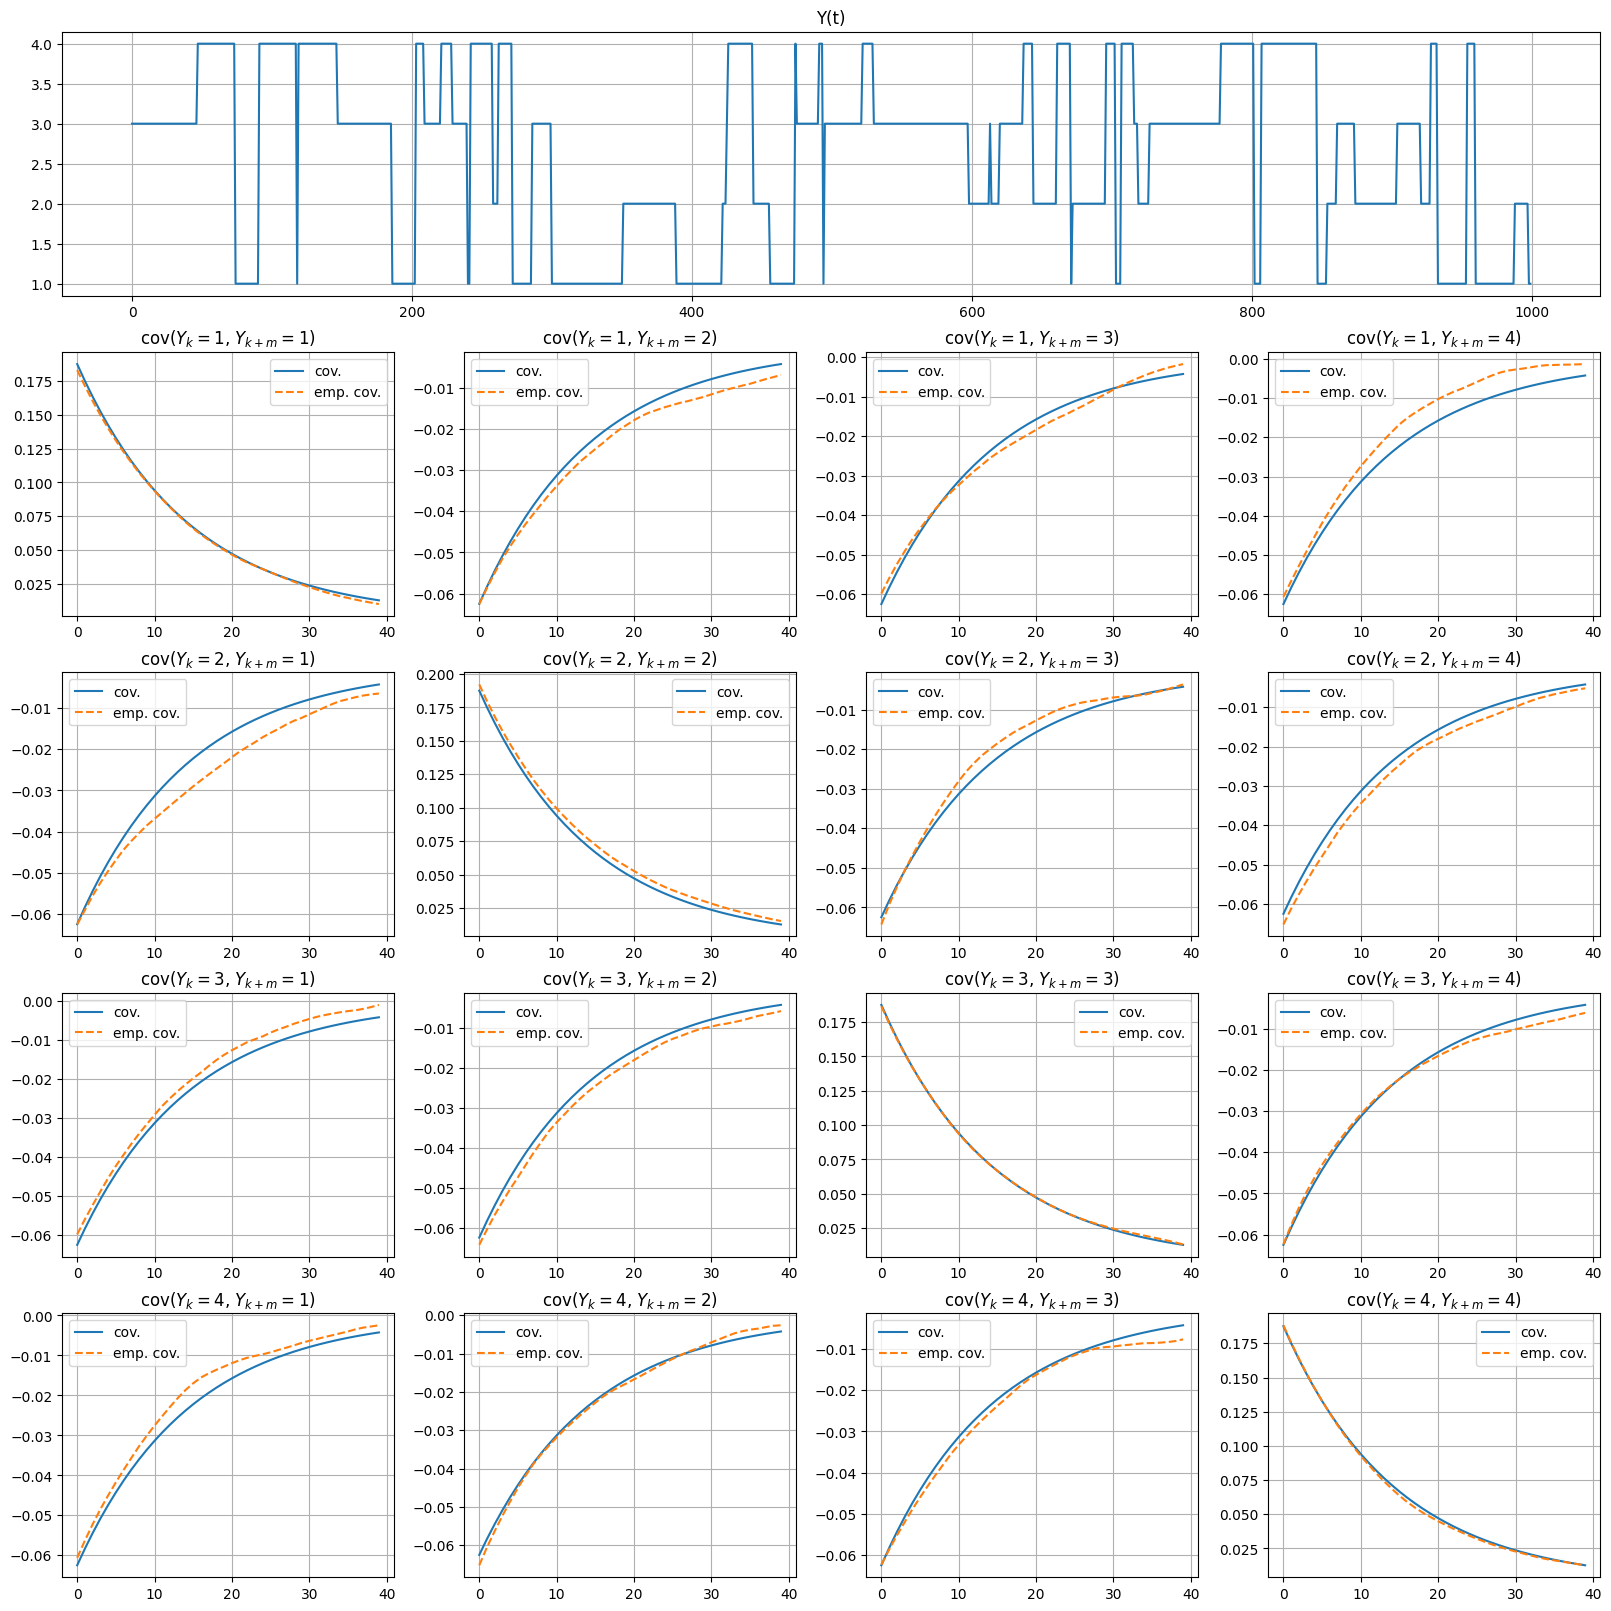

In [5]:
# Unconditional markov chain
# --------------------------
# Length of the chain
ylength = 50000

# Simulation
np.random.seed(123)
y = gn.markovChain.simulate_mc(kernel, ylength, categVal=categVal, nreal=1)
# -> y is an array of shape (nreal, length)

# Compute empirical invariant distribution
pinv_emp = np.array([np.mean(y==categVal[i]) for i in range(ncat)])

# Compute empirical covariance function
nlag = 40
cov_y_emp = np.zeros((nlag, ncat, ncat))
for i in range(ncat):
    for j in range(ncat):
        cov_y_emp[:, i, j] = np.array(
            [np.cov(y[0,m:]==categVal[j], y[0,:y.shape[1]-m]==categVal[i])[0,1] for m in range(nlag)])

# Theoretical covariances
cov_y = gn.markovChain.compute_mc_cov(kernel, nsteps=nlag)

print("Kernel:\n", kernel)
print("Invariant distribution, empirical (pinv_emp):", pinv_emp)
print("Invariant distribution, theoretical (pinv)  :", pinv)

# Plot Y simulation and covariances
# ---------------------------------
fig = plt.figure(figsize=(16, 16), constrained_layout=True)

gs = GridSpec(ncat+1, ncat, figure=fig)
ax = fig.add_subplot(gs[0, :])
plt.sca(ax)
plt.plot(y[0,:min(ylength, 1000)])
plt.grid()
plt.title('Y(t)')

for i in range(ncat):
    for j in range(ncat):
        ax = fig.add_subplot(gs[1+i, j])
        plt.sca(ax)
        ax.plot(cov_y[:,i,j], label='cov.')
        plt.plot(cov_y_emp[:,i,j], ls='dashed', label='emp. cov.')
        plt.legend()
        plt.grid()
        plt.title('cov($Y_{}={}$, $Y_{}={}$)'.format('{k}', categVal[i], '{k+m}', categVal[j]))

plt.show()

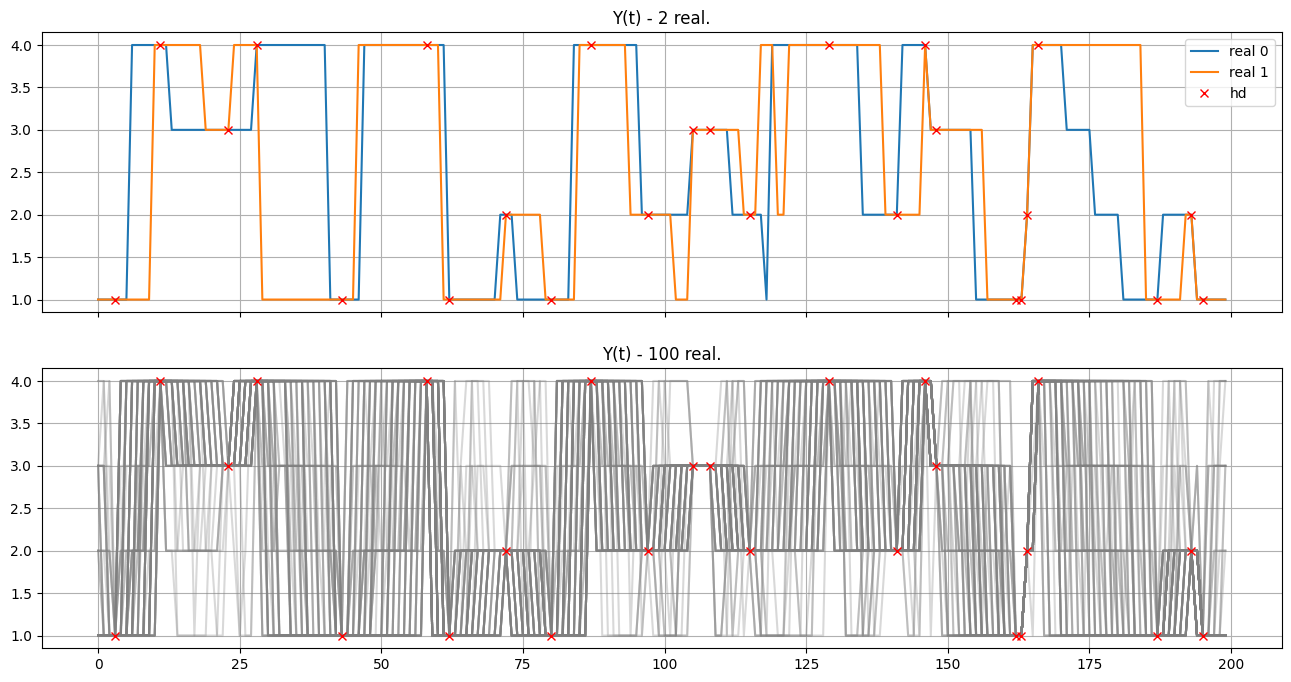

In [6]:
# Conditional markov chain
# ------------------------
# Length of the chain
ylength = 200

# Conditioning points
nhd = 25
np.random.seed(85938)
yind = np.random.choice(ylength, size=nhd, replace=False)
yval = np.random.choice(categVal, size=nhd, replace=True)

# Simulation
np.random.seed(123)
nreal=100
y = gn.markovChain.simulate_mc(kernel, ylength, categVal=categVal, data_ind=yind, data_val=yval, nreal=nreal)

# Plot 2 real. and ensemble of real.
# ----------------------------------
plt.subplots(2,1, sharex=True, figsize=(16, 8))
plt.subplot(2,1,1)

plt.plot(y[0, :min(ylength, 1000)], label=f'real 0')
plt.plot(y[1, :min(ylength, 1000)], label=f'real 1')
plt.plot(yind, yval, 'rx', label='hd')
plt.grid()
plt.legend()
plt.title('Y(t) - 2 real.')

plt.subplot(2,1,2)
for i in range(nreal):
    plt.plot(y[i, :min(ylength, 1000)], c='gray', alpha=.3)

plt.plot(yind, yval, 'rx')
plt.grid()
plt.title(f'Y(t) - {nreal} real.')
plt.show()